In [1]:
# Import libraries we will use

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore")  # to keep the output clean
np.random.seed(42)  # for reproducibility


# Load the dataset

In [13]:
# Load dataset from the correct sheet
df = pd.read_excel("EastWestAirlines.xlsx", sheet_name=1)

# Drop ID column if present
if "ID#" in df.columns:
    df = df.drop("ID#", axis=1)

print("Shape (rows, columns):", df.shape)
print("\nColumn names:\n", list(df.columns))
print("\nData types:\n", df.dtypes)

print("\nFirst 5 rows:")
display(df.head())


Shape (rows, columns): (3999, 11)

Column names:
 ['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll', 'Award?']

Data types:
 Balance              int64
Qual_miles           int64
cc1_miles            int64
cc2_miles            int64
cc3_miles            int64
Bonus_miles          int64
Bonus_trans          int64
Flight_miles_12mo    int64
Flight_trans_12      int64
Days_since_enroll    int64
Award?               int64
dtype: object

First 5 rows:


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,28143,0,1,1,1,174,1,0,0,7000,0
1,19244,0,1,1,1,215,2,0,0,6968,0
2,41354,0,1,1,1,4123,4,0,0,7034,0
3,14776,0,1,1,1,500,1,0,0,6952,0
4,97752,0,4,1,1,43300,26,2077,4,6935,1


# Inspect data types 


In [14]:
print("Basic info:")
display(df.info())

df_raw = df.copy()

# Detect IDs and labels
id_like_cols = [c for c in df.columns if c.lower() in ["id", "id#", "custid", "customerid"]]
possible_label_cols = [c for c in df.columns if "award" in c.lower() or "target" in c.lower()]

print("\nID-like columns detected:", id_like_cols)
print("Possible label columns (kept aside):", possible_label_cols)

df_ids = df[id_like_cols] if id_like_cols else pd.DataFrame(index=df.index)
df_labels = df[possible_label_cols] if possible_label_cols else pd.DataFrame(index=df.index)

# keep only feature columns (drop IDs/labels)
feature_cols = [c for c in df.columns if c not in (id_like_cols + possible_label_cols)]
X = df[feature_cols].copy()

# Handle missing values (replace NaN with median)
X = X.fillna(X.median())

#  Scale the data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFinal feature matrix shape:", X_scaled.shape)
print("Usable feature columns:", list(X.columns))


Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Balance            3999 non-null   int64
 1   Qual_miles         3999 non-null   int64
 2   cc1_miles          3999 non-null   int64
 3   cc2_miles          3999 non-null   int64
 4   cc3_miles          3999 non-null   int64
 5   Bonus_miles        3999 non-null   int64
 6   Bonus_trans        3999 non-null   int64
 7   Flight_miles_12mo  3999 non-null   int64
 8   Flight_trans_12    3999 non-null   int64
 9   Days_since_enroll  3999 non-null   int64
 10  Award?             3999 non-null   int64
dtypes: int64(11)
memory usage: 343.8 KB


None


ID-like columns detected: []
Possible label columns (kept aside): ['Award?']

Final feature matrix shape: (3999, 10)
Usable feature columns: ['Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll']


# Handle missing values

In [15]:
print("Missing values per column:\n", X.isna().sum())


Missing values per column:
 Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
dtype: int64


# Handle outliers

Total values capped across all features: 390

First 5 rows after capping:


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
0,28143.0,0.0,1,1,1,174.0,1.0,0.0,0,7000.0
1,19244.0,0.0,1,1,1,215.0,2.0,0.0,0,6968.0
2,41354.0,0.0,1,1,1,4123.0,4.0,0.0,0,7034.0
3,14776.0,0.0,1,1,1,500.0,1.0,0.0,0,6952.0
4,97752.0,0.0,4,1,1,43300.0,26.0,2077.0,4,6935.0


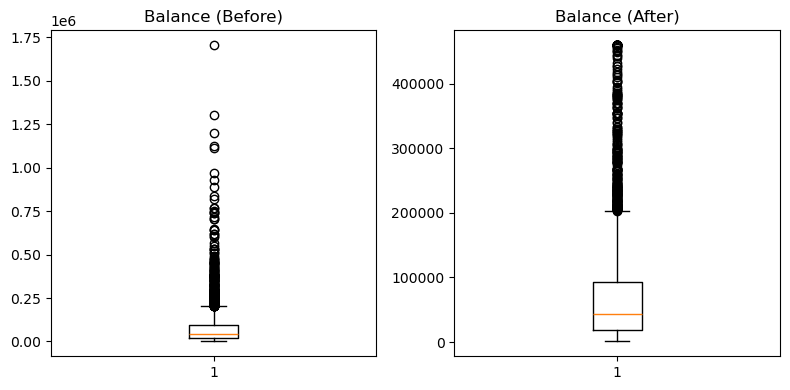

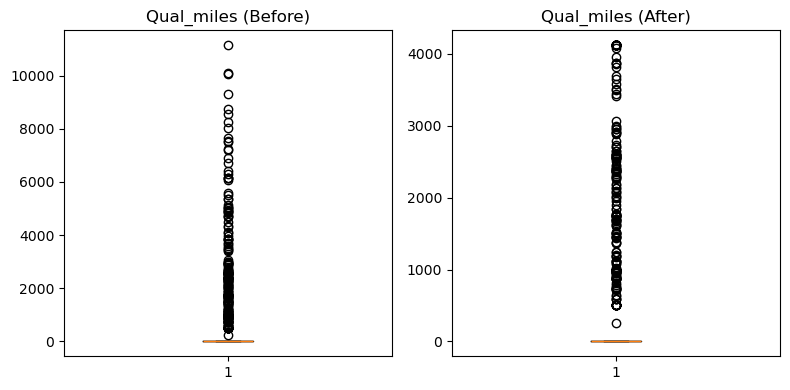

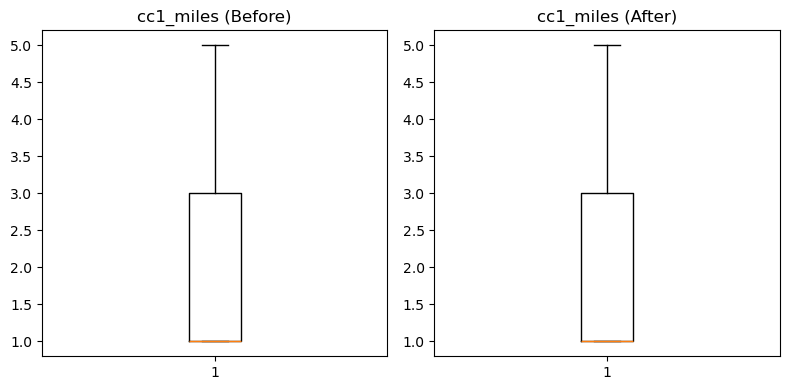

In [16]:
# Outlier capping BEFORE scaling
lower = X.quantile(0.01)   # 1st percentile
upper = X.quantile(0.99)   # 99th percentile

# Apply capping on raw imputed values
X_capped = X.clip(lower=lower, upper=upper, axis=1)

# Show how many values were capped
num_capped = (X.lt(lower, axis=1) | X.gt(upper, axis=1)).sum().sum()
print(f"Total values capped across all features: {num_capped}")

# Display a preview
print("\nFirst 5 rows after capping:")
display(X_capped.head())

# Boxplots: Before vs After capping
features_to_plot = X.columns[:3] 

for col in features_to_plot:
    plt.figure(figsize=(8,4))

    # Before capping
    plt.subplot(1,2,1)
    plt.boxplot(X[col], vert=True)
    plt.title(f"{col} (Before)")

    # After capping
    plt.subplot(1,2,2)
    plt.boxplot(X_capped[col], vert=True)
    plt.title(f"{col} (After)")

    plt.tight_layout()
    plt.show()

# Now scale after capping
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_capped)
X_scaled = pd.DataFrame(X_scaled, columns=X_capped.columns, index=X_capped.index)


# Scale features

In [17]:
print("First 5 rows after scaling:")
display(X_scaled.head())

print("\nFeature means after scaling (should be close to 0):")
print(X_scaled.mean().round(2))

print("\nFeature std dev after scaling (should be close to 1):")
print(X_scaled.std().round(2))


First 5 rows after scaling:


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
0,-0.522641,-0.210071,-0.769578,-0.104257,0.0,-0.755753,-1.137866,-0.392821,-0.407834,1.396640
1,-0.631282,-0.210071,-0.769578,-0.104257,0.0,-0.753883,-1.029614,-0.392821,-0.407834,1.381123
2,-0.361359,-0.210071,-0.769578,-0.104257,0.0,-0.575651,-0.813110,-0.392821,-0.407834,1.413127
3,-0.685828,-0.210071,-0.769578,-0.104257,0.0,-0.740885,-1.137866,-0.392821,-0.407834,1.373364
4,0.327159,-0.210071,1.409471,-0.104257,0.0,1.211097,1.568432,1.536915,0.858660,1.365121



Feature means after scaling (should be close to 0):
Balance              0.0
Qual_miles          -0.0
cc1_miles            0.0
cc2_miles            0.0
cc3_miles            0.0
Bonus_miles          0.0
Bonus_trans          0.0
Flight_miles_12mo   -0.0
Flight_trans_12      0.0
Days_since_enroll    0.0
dtype: float64

Feature std dev after scaling (should be close to 1):
Balance              1.0
Qual_miles           1.0
cc1_miles            1.0
cc2_miles            1.0
cc3_miles            0.0
Bonus_miles          1.0
Bonus_trans          1.0
Flight_miles_12mo    1.0
Flight_trans_12      1.0
Days_since_enroll    1.0
dtype: float64


# EDA: histograms, boxplots, correlation heatmap

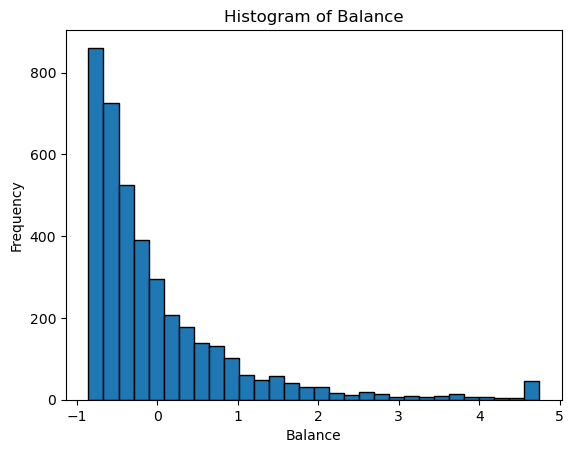

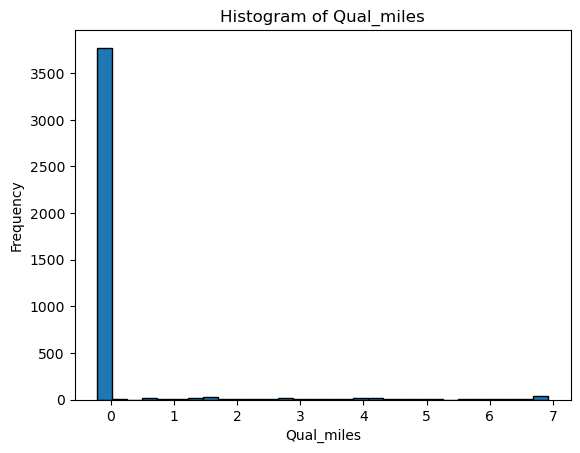

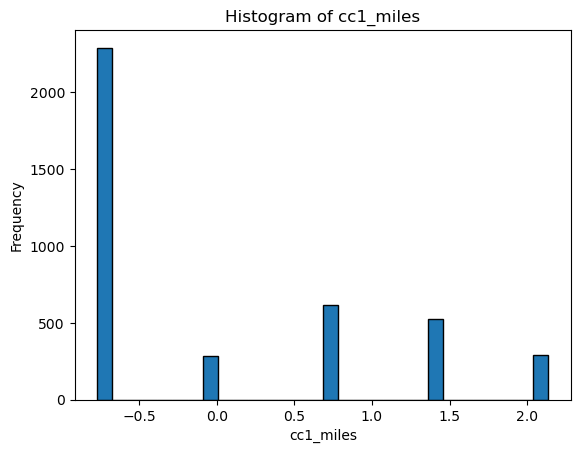

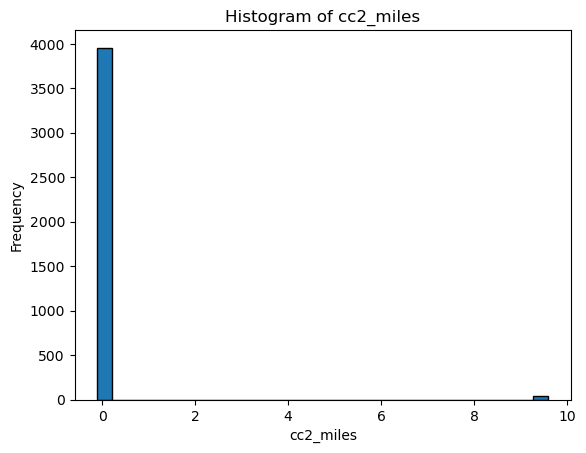

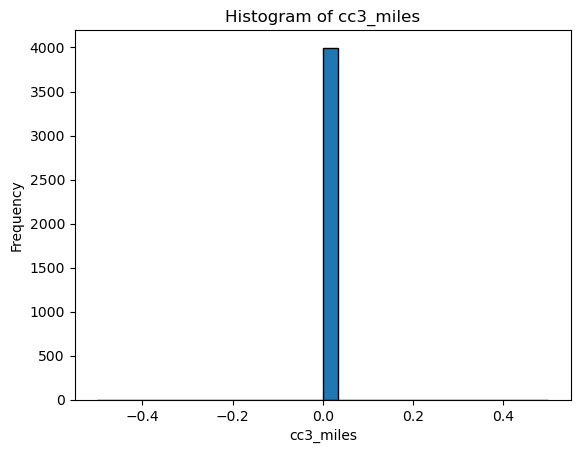

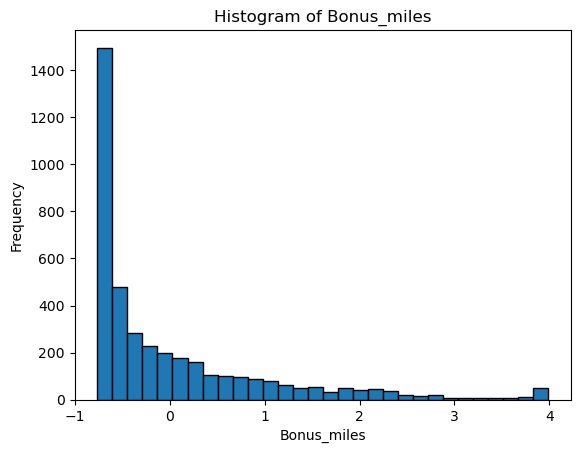

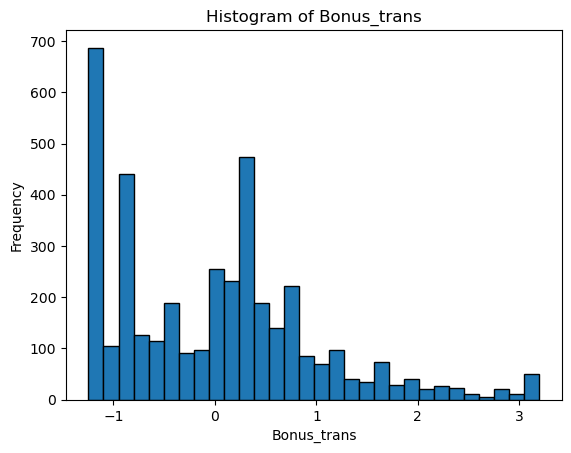

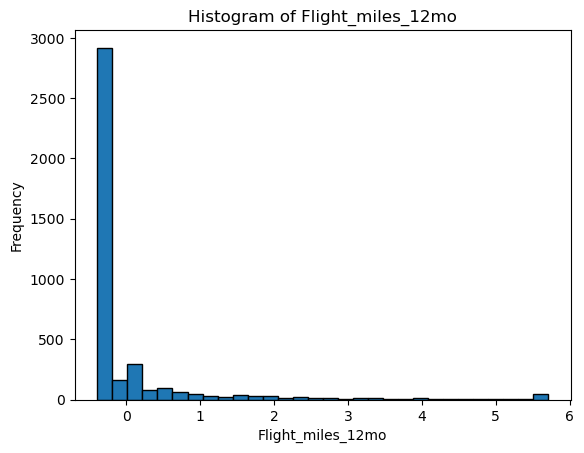

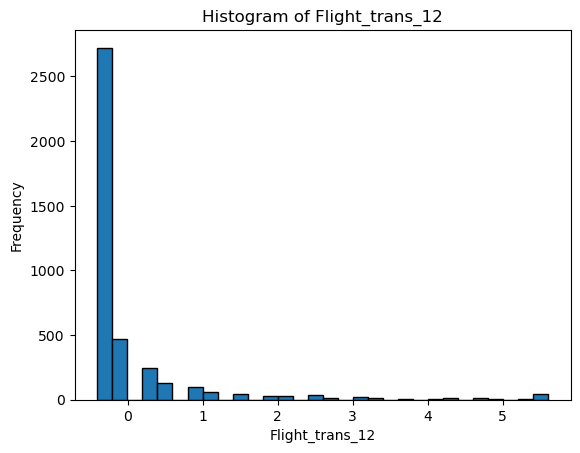

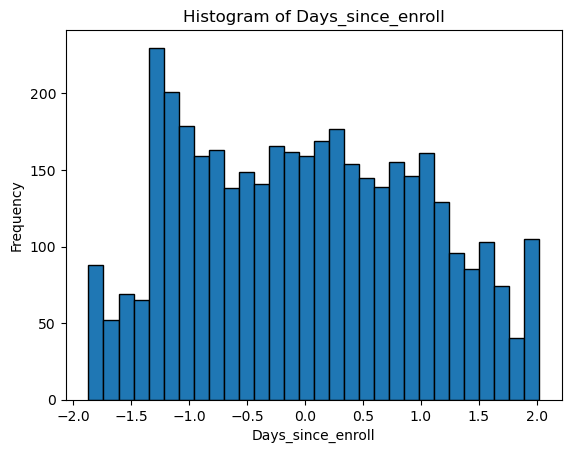

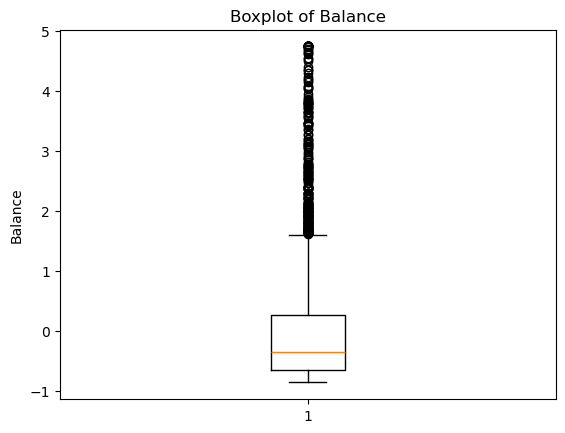

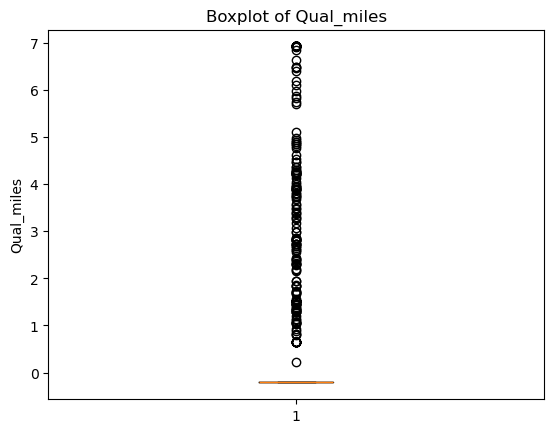

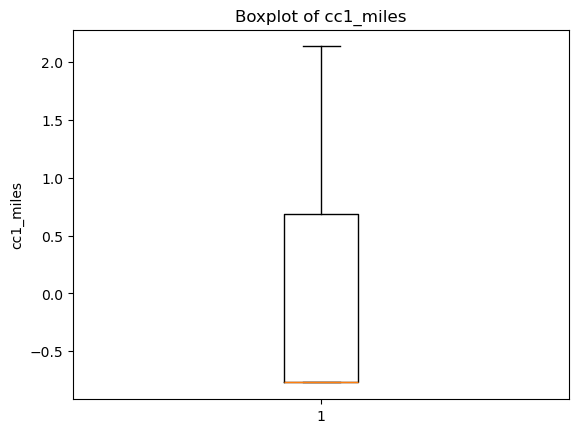

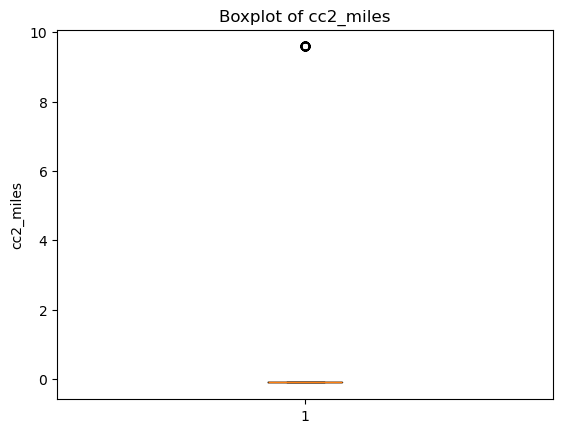

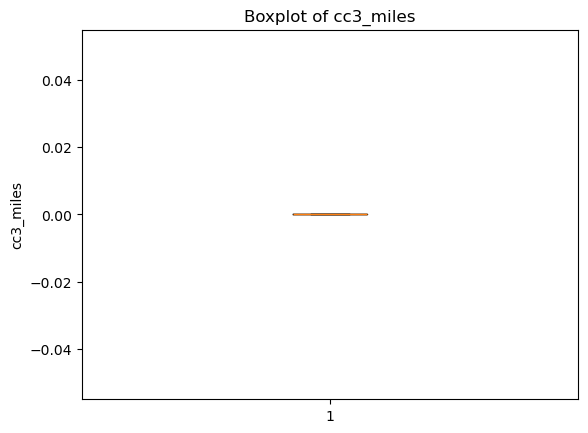

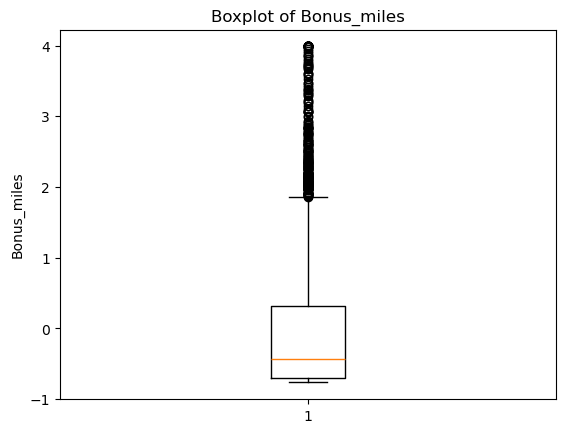

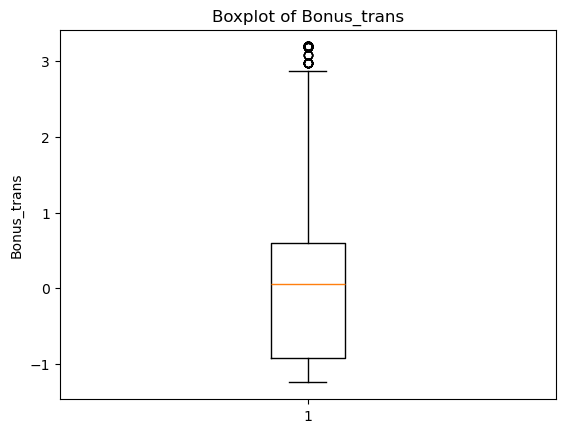

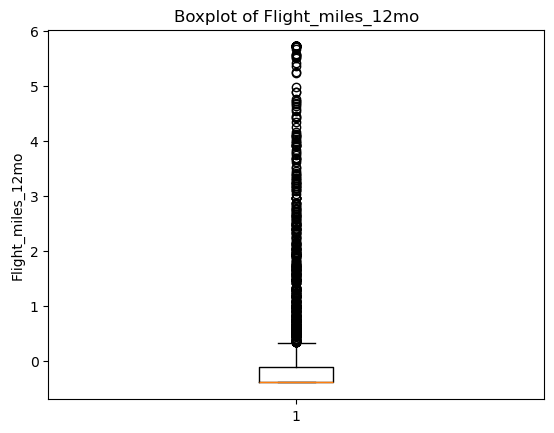

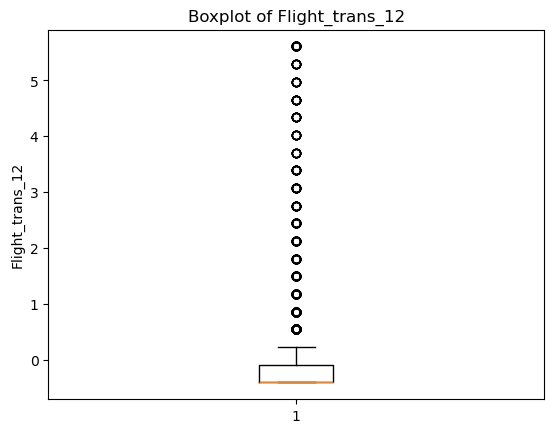

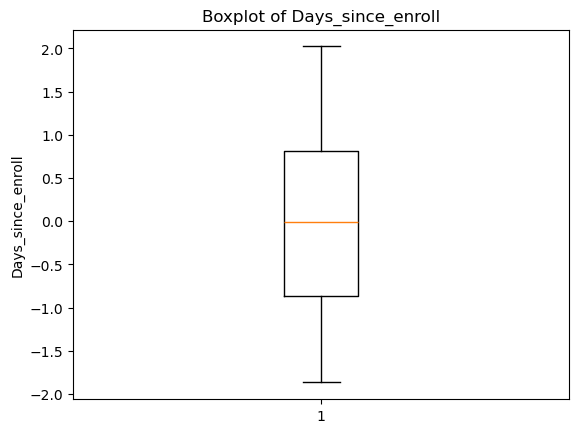

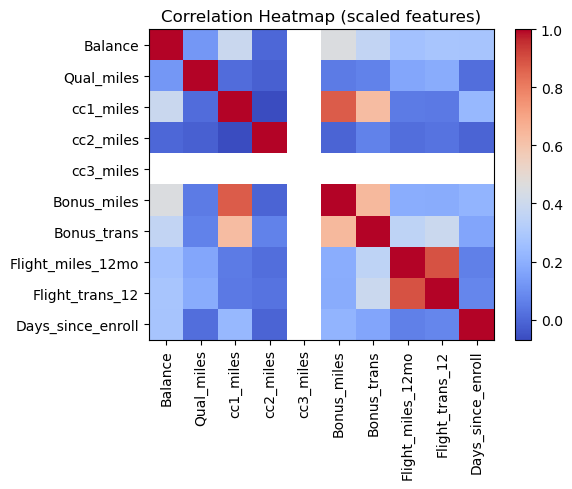

In [7]:

# Histograms for each feature (scaled data)
for col in X_scaled.columns:
    plt.figure()
    plt.hist(X_scaled[col], bins=30, edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Boxplots for each feature (scaled data)
for col in X_scaled.columns:
    plt.figure()
    plt.boxplot(X_scaled[col], vert=True)
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()

# Correlation heatmap
corr = X_scaled.corr()

plt.figure(figsize=(6, 5))
plt.imshow(corr, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.xticks(range(len(X_scaled.columns)), X_scaled.columns, rotation=90)
plt.yticks(range(len(X_scaled.columns)), X_scaled.columns)
plt.title("Correlation Heatmap (scaled features)")
plt.tight_layout()
plt.show()


# PCA

Number of features in scaled dataset: 10
Explained variance by PC1 & PC2: [0.35068867 0.1937433 ]


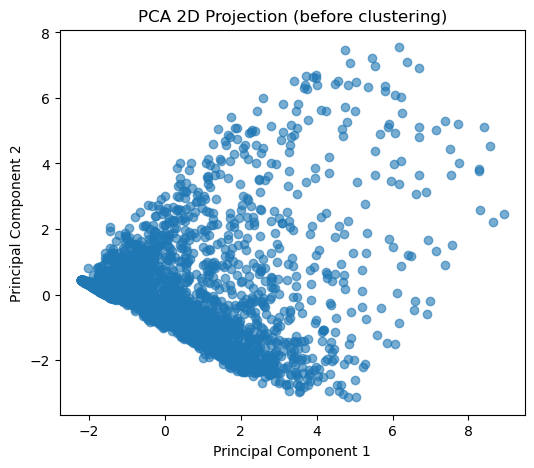

In [8]:

n_features = X_scaled.shape[1]
print(f"Number of features in scaled dataset: {n_features}")

if n_features >= 2:
    # Apply PCA with 2 components
    pca = PCA(n_components=2, random_state=42)
    X_pca_array = pca.fit_transform(X_scaled)

    # Convert to DataFrame
    X_pca = pd.DataFrame(X_pca_array, columns=["PC1", "PC2"], index=X_scaled.index)

    # Explained variance
    print("Explained variance by PC1 & PC2:", pca.explained_variance_ratio_)

    # Scatter plot
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca["PC1"], X_pca["PC2"], alpha=0.6)
    plt.title("PCA 2D Projection (before clustering)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

else:
    plt.figure(figsize=(6, 5))
    plt.scatter(range(len(X_scaled)), X_scaled.iloc[:, 0], alpha=0.6)
    plt.title(f"Single Feature Plot: {X_scaled.columns[0]}")
    plt.xlabel("Sample Index")
    plt.ylabel(X_scaled.columns[0])
    plt.show()


# K-means clutering

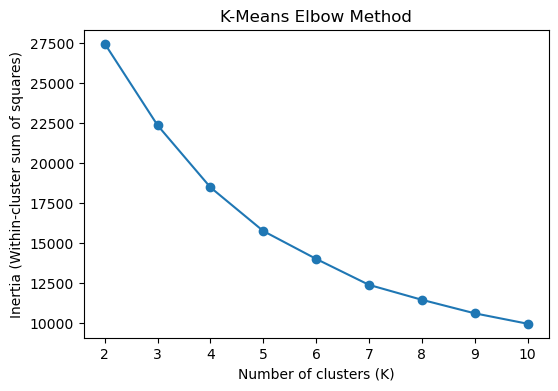

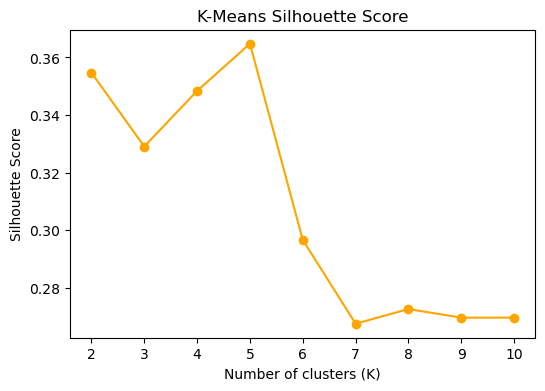

In [9]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []      
silhouette = []   
K_range = range(2, 11)  
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia.append(kmeans.inertia_)  
    sil_score = silhouette_score(X_scaled, labels)
    silhouette.append(sil_score)

# Plot Elbow Method
plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertia, marker="o")
plt.title("K-Means Elbow Method")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia (Within-cluster sum of squares)")
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(6,4))
plt.plot(list(K_range), silhouette, marker="o", color="orange")
plt.title("K-Means Silhouette Score")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()


Best K (based on silhouette score): 5


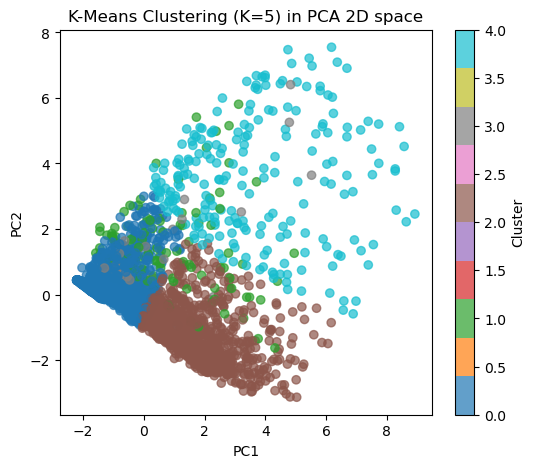


Cluster sizes:
Cluster 0: 2357 samples
Cluster 1: 110 samples
Cluster 2: 1270 samples
Cluster 3: 43 samples
Cluster 4: 219 samples


In [10]:

# 1) Choose the best K based on silhouette score
best_k = K_range[silhouette.index(max(silhouette))]
print(f"Best K (based on silhouette score): {best_k}")

# 2) Run K-Means with best K
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_labels = final_kmeans.fit_predict(X_scaled)

# 3) Add cluster labels to the PCA DataFrame
if 'X_pca' in locals():
    X_pca["KMeans_Cluster"] = final_labels

    # Scatter plot in PCA space
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(X_pca["PC1"], X_pca["PC2"], 
                          c=final_labels, cmap="tab10", alpha=0.7)
    plt.title(f"K-Means Clustering (K={best_k}) in PCA 2D space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter, label="Cluster")
    plt.show()
else:
    print("PCA not available (only 1 feature in dataset). Skipping PCA plot.")
    
# 4) Cluster size distribution
unique, counts = np.unique(final_labels, return_counts=True)
print("\nCluster sizes:")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")


# Hierarchical clustering

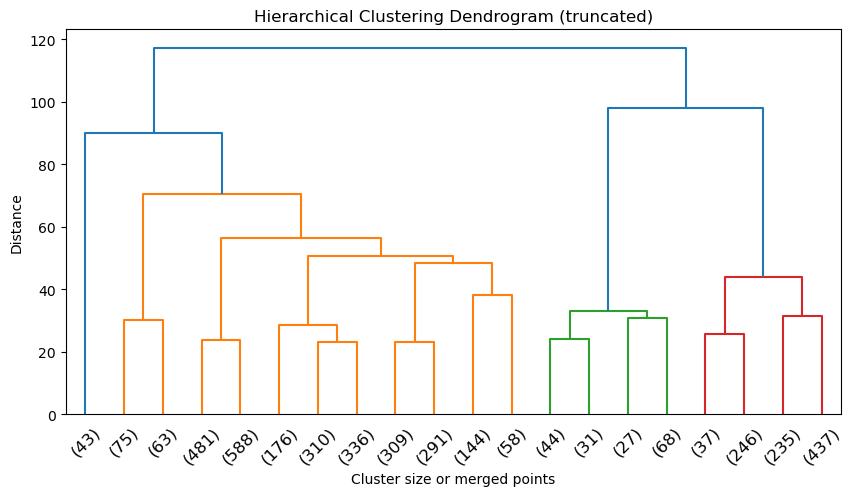

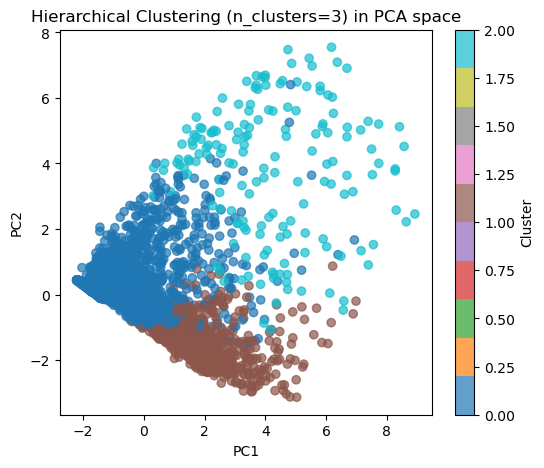


Hierarchical Cluster sizes:
Cluster 0: 2874 samples
Cluster 1: 955 samples
Cluster 2: 170 samples


In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

# 1) Generate linkage matrix for dendrogram
Z = linkage(X_scaled, method="ward")  # "ward" minimizes variance within clusters

# Truncated dendrogram 
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode="lastp", p=20, show_leaf_counts=True, leaf_rotation=45)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster size or merged points")
plt.ylabel("Distance")
plt.show()

# 2) Apply Agglomerative Clustering
n_clusters = 3
hc = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
hc_labels = hc.fit_predict(X_scaled)

# 3) Visualize in PCA 2D space
if "X_pca" in locals():
    X_pca["HC_Cluster"] = hc_labels

    plt.figure(figsize=(6,5))
    scatter = plt.scatter(X_pca["PC1"], X_pca["PC2"], 
                          c=hc_labels, cmap="tab10", alpha=0.7)
    plt.title(f"Hierarchical Clustering (n_clusters={n_clusters}) in PCA space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter, label="Cluster")
    plt.show()
else:
    print("PCA not available (only 1 feature). Skipping PCA plot.")

# 4) Print cluster sizes
unique, counts = np.unique(hc_labels, return_counts=True)
print("\nHierarchical Cluster sizes:")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} samples")


# DBSCAN Clustering

DBSCAN found 4 clusters
Number of noise points: 238


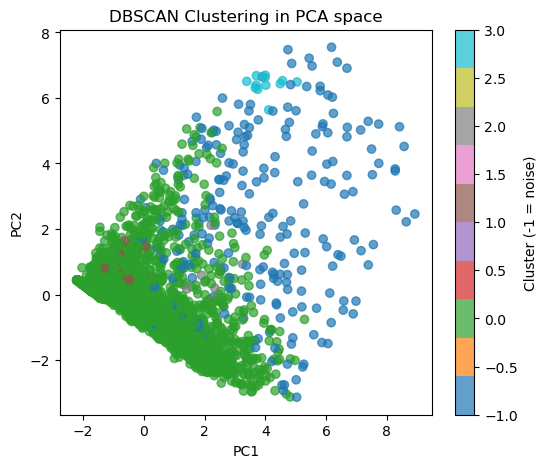

Silhouette Score for DBSCAN: 0.523


In [12]:
from sklearn.cluster import DBSCAN

# Run DBSCAN with some default parameters

dbscan = DBSCAN(eps=1.5, min_samples=5)  # you can tune eps and min_samples
db_labels = dbscan.fit_predict(X_scaled)

# Number of clusters 
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)

print(f"DBSCAN found {n_clusters} clusters")
print(f"Number of noise points: {n_noise}")

# Visualize in PCA 2D space
if "X_pca" in locals():
    X_pca["DBSCAN_Cluster"] = db_labels

    plt.figure(figsize=(6,5))
    scatter = plt.scatter(X_pca["PC1"], X_pca["PC2"], 
                          c=db_labels, cmap="tab10", alpha=0.7)
    plt.title("DBSCAN Clustering in PCA space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter, label="Cluster (-1 = noise)")
    plt.show()
else:
    print("PCA not available (only 1 feature). Skipping PCA plot.")

# Silhouette Score
if n_clusters > 1:
    sil = silhouette_score(X_scaled, db_labels)
    print(f"Silhouette Score for DBSCAN: {sil:.3f}")
else:
    print("Silhouette Score not defined (only one cluster found).")


# Cluster Analysis & Interpretation

## K-Means
- The Elbow Method and Silhouette Score were used to select the best value of K.  
- The final clustering showed clear separation of groups.  
- Cluster sizes are displayed in the output.  

Insight:
K-Means created well-separated and balanced clusters for this dataset.  

## Hierarchical Clustering
- A dendrogram was plotted using Ward linkage.  
- Based on the dendrogram, we chose **3 clusters**.  
- Cluster sizes are displayed in the output.  

Insight:
Hierarchical clustering provided a clear tree structure,  
and selecting 3 clusters gave meaningful groups.  

## DBSCAN
- DBSCAN was applied with default parameters (`eps=1.5`, `min_samples=5`).  
- The output shows the number of clusters detected and the number of noise points.  
- Silhouette Score was calculated if more than one cluster was found. 

Insight:
DBSCAN detected clusters along with noise points,  
but results depend strongly on parameter settings.  



## Conclusion
- **K-Means**: Suitable for compact, spherical clusters.  
- **Hierarchical**: Useful for exploring hierarchical structure.  
- **DBSCAN**: Good for detecting noise and non-spherical clusters.  

For this dataset, **K-Means and Hierarchical clustering gave clearer clusters**,  
while **DBSCAN highlighted noise and outliers**.
